# Fig.1

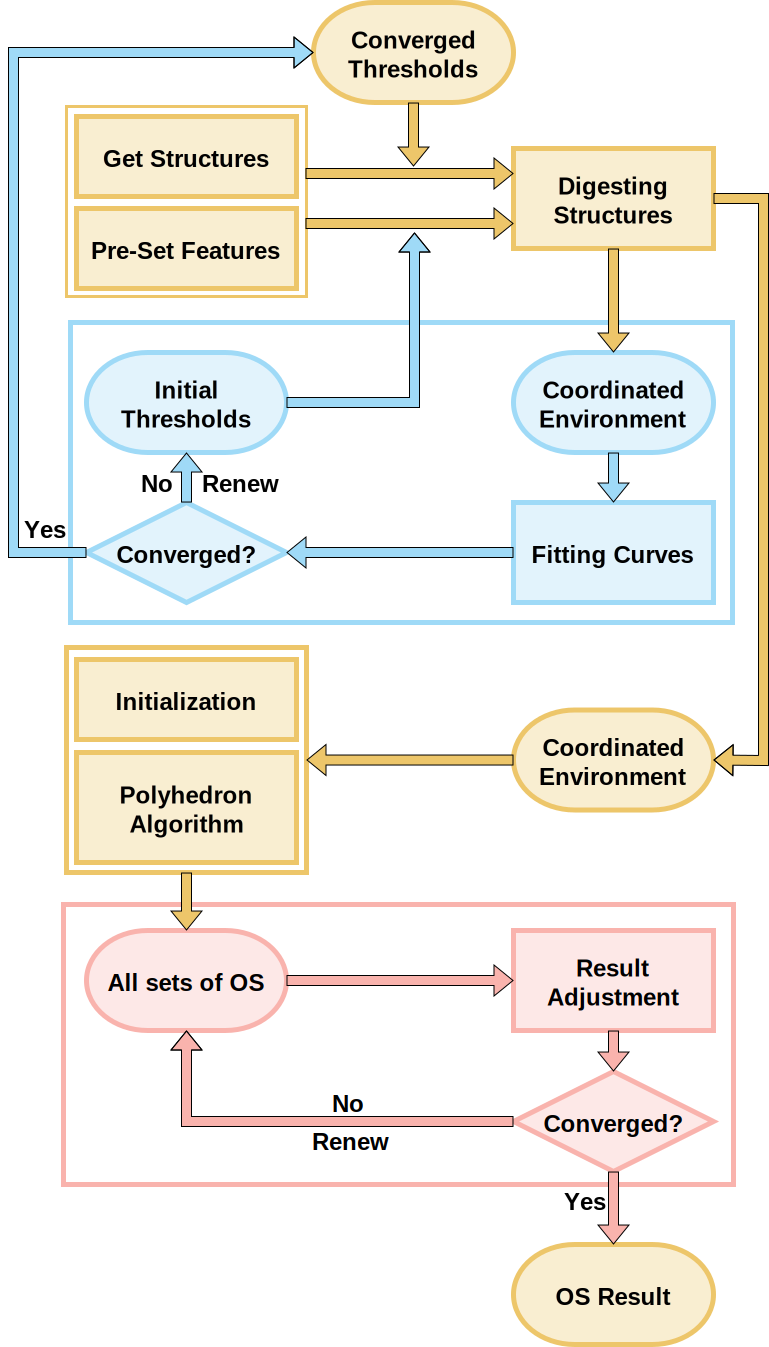

In [1]:
from IPython.display import SVG, display
svg_file_path = 'Fig_1.svg'
display(SVG(svg_file_path))

# Fig.2

In [2]:
import pandas as pd
import numpy as np
import pickle
from scipy.optimize import curve_fit

OV = pd.read_csv("../redefined_length_csv/bond_of_O_V.csv", header=None)[0].tolist()
OAl = pd.read_csv("../redefined_length_csv/bond_of_O_Al.csv", header=None)[0].tolist()

with open("../fitting_info_dict.pkl", "rb") as f:
    fitting_info = pickle.load(f)


def refine_data(Min, Max, step, target_list):
    stations = np.arange(Min, Max + step, step)
    stations = np.round(stations, 3)
    def find_station(value):
        station_indices = np.searchsorted(stations, value, side='right') - 1
        return stations[max(station_indices, 0)]
    processed_list = [find_station(value) for value in target_list]
    return processed_list

def length_2_distribution(length, t):
    length = [l for l in length if t >= l > 0.1]
    Min, Max = min(length), max(length)
    Step = round(((Max-Min)/50),3)
    refined_distance = refine_data(Min, Max, Step, length)
    unique_values, counts = np.unique(refined_distance, return_counts=True)
    return unique_values, counts/sum(counts)


class GaussianModel:
    def __init__(self, num_gaussians):
        self.num_gaussians = num_gaussians

    def gaussian(self, x, *params):
        y = np.zeros_like(x)
        for i in range(self.num_gaussians):
            amplitude = params[i*3]
            mean = params[i*3+1]
            stddev = params[i*3+2]
            y += amplitude * np.exp(-((x - mean) ** 2) / (2 * (stddev ** 2)))
        return y

    def fit(self,x,y,means,sigmas):
        initial_guesses = []
        lower_bounds = []
        upper_bounds = []
        for mean,sigma in zip(means,sigmas):
            initial_guesses.extend([0.2, mean, sigma])
            lower_bounds.extend([0, mean-0.001, sigma-0.001])
            upper_bounds.extend([1, mean+0.001, sigma+0.001])

        bounds = (lower_bounds, upper_bounds)
        popt, _ = curve_fit(self.gaussian, x, y, p0=initial_guesses, bounds=bounds)
        y_pred = [self.gaussian(X, *popt) for X in x]
        self.popt = popt
        return popt,y_pred
    
    def single_fit(self,x):
        return self.gaussian(x, *self.popt)
        

In [3]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt


###
OV_lines = {"V5O4":(1.75,1.77),"V5O5":(1.84,1.92),"V5O6":(1.89,1.95),"V4O6":(1.97,2.02),"V3O6":(1.99,2.04)}
OAl_lines = {"Al3O6":(1.757),"Al3O4":(1.895)}
###

fig,gs = plt.figure(figsize=(54,16), dpi=300), GridSpec(1,3)
ax1,ax2,ax4 = plt.subplot(gs[0:1,0:1]),plt.subplot(gs[0:1,1:2]),plt.subplot(gs[0:1,2:3])
GM = GaussianModel(2)


label_size = 48
legend_size = 48
tick_size = 36
line_size = 6
text_size = 48



# PLOT ONE ###################################
r2,mean1,sigma1,mean2,sigma2,threshold = fitting_info[("O", "Al")].values()
print(mean1,mean2,sigma1,sigma2)
x,y = length_2_distribution(OAl, threshold)
popt, y_pred = GM.fit(x,y,[mean1,mean2],[sigma1,sigma2])
ax1.plot(x,y, linewidth=line_size, c="#0088FF", label="Distance Distribution")
ax1.plot(x, y_pred, linewidth=line_size, c="#FF9333", label="Fitting Line")
ax1.axvline(x=threshold, linestyle="-.",c="#FF0044", linewidth=line_size)#, label="Threshold")
ax1.text(0.95, 0.85, 'Threshold=%sÅ'%threshold, fontsize=text_size, fontname='Arial', ha='right', va='top', transform=ax1.transAxes)

for se_coords in OAl_lines.values():
    avg_x = np.average(se_coords)

ax1.tick_params(axis='x', labelsize=tick_size)
ax1.tick_params(axis='y', labelsize=tick_size)
ax1.set_xlim([min(x)-0.05,max(x)+0.05])
ax1.set_ylim([-0.002,max(y)+0.008])
ax1.set_xlabel("Distance between O and Al (Å)", fontsize=label_size, fontname='Arial')
ax1.set_ylabel("Frequency", fontsize=label_size, fontname='Arial')
legend1 = ax1.legend(loc='upper left', prop={'size': legend_size, 'family': 'Arial'}, frameon=False)
legend1.set_zorder(1)



# PLOT TWO #####################################
r2,mean1,sigma1,mean2,sigma2,threshold = fitting_info[("O", "V")].values()
print(mean1,mean2,sigma1,sigma2)
x,y = length_2_distribution(OV, threshold)
popt, y_pred = GM.fit(x,y,[mean1,mean2],[sigma1,sigma2])
ax2.plot(x,y, linewidth=line_size, c="#0088FF", label="Distance Distribution")
ax2.plot(x, y_pred, linewidth=line_size, c="#FF9333", label="Fitting Line")
ax2.axvline(x=threshold, linestyle="-.",c="#FF0044", linewidth=line_size)
ax2.text(0.95, 0.85, 'Threshold=%sÅ'%threshold, fontsize=text_size, fontname='Arial', ha='right', va='top', transform=ax2.transAxes)

for se_coords in OV_lines.values():
    avg_x = np.average(se_coords)
    ax2.text(avg_x, 0, '{', fontsize=text_size, rotation=-90, ha='center', va='center')

ax2.tick_params(axis='x', labelsize=tick_size)
ax2.tick_params(axis='y', labelsize=tick_size)
ax2.set_xlim([min(x)-0.05,max(x)+0.05])
ax2.set_ylim([-0.001,max(y)+0.008])
ax2.set_xlabel("Distance between O and V (Å)", fontsize=label_size, fontname='Arial')
ax2.set_ylabel("Frequency", fontsize=label_size, fontname='Arial')
legend2 = ax2.legend(loc='upper left', prop={'size': legend_size, 'family': 'Arial'}, frameon=False)
legend2.set_zorder(1)



#PLOT FOUR
openexcel = pd.read_excel('../pre_set.xlsx', sheet_name = "Radii_X") 
dic_s = openexcel.set_index("symbol").to_dict()["single"]
pyykko_list, threshold_list = [], []
for k,v in fitting_info.items():
    threshold_list.append(v["threshold"])
    pyykko_list.append(np.array(dic_s[k[0]]+dic_s[k[1]])*0.01)
pyykko_list, threshold_list = np.array(pyykko_list), np.array(threshold_list)
b = np.linspace(0, 7, 100)
ax4.scatter(pyykko_list, threshold_list, color='#0088FF', label='Thresholds', alpha=1)
ax4.fill([0, 7, 7/2], [0, 7*1.5, 7*1.5], color='#F9B3AD', alpha=0.3, label='Larger than 1.5×Sum', linewidth=0) 
ax4.fill([0, 7, 7], [0, 7, 7*1.5], color='#0088FF', alpha=0.3, label='Between 1.0×Sum and 1.5×Sum', linewidth=0) 
ax4.plot([0, 7], [0, 10.5], linestyle='--', color='#D9DEE7', linewidth=line_size)

ax4.tick_params(axis='x', labelsize=tick_size)
ax4.tick_params(axis='y', labelsize=tick_size)
ax4.set_xlim([0,6.5])
ax4.set_ylim([0,6.5])
ax4.set_xlabel("Sum of Pyykkö's single-bond covalent radii", fontsize=label_size, fontname='Arial')
ax4.set_ylabel("Threshold", fontsize=label_size, fontname='Arial')
ax4.legend(loc='lower right', prop={'size': legend_size, 'family': 'Arial'}, frameon=False,markerfirst=False)

for ax in [ax1, ax2, ax4]:
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)  # Set linewidth to make the axes bold

plt.subplots_adjust(left=0.05, right=0.98, bottom=0.08, top=0.98, wspace=0.3)
plt.savefig("Fig_2.svg")

1.757 1.895 0.022 0.065
1.722 1.995 0.059 0.1


# Fig.3

In [4]:
import json
import pickle
import numpy as np

file_get = open("../fitting_info_dict.pkl",'rb') 
fitting_info_dict = pickle.load(file_get) 
file_get.close()


element_list = ['H' ,                                                                                                 'He', 
                'Li', 'Be',                                                             'B' , 'C' , 'N' , 'O' , 'F' , 'Ne', 
                'Na', 'Mg',                                                             'Al', 'Si', 'P' , 'S' , 'Cl', 'Ar', 
                'K' , 'Ca', 'Sc', 'Ti', 'V' , 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 
                'Rb', 'Sr', 'Y' , 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I' , 'Xe', 
                'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 
                                  'Hf', 'Ta', 'W' , 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn',
                'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U' , 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr',
                                  'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


np_element = np.array([
"H"   ,"None","None","None","None","None","None","None","None","None","None","None","None","None","None","None","None","He"  , 
"Li"  ,"Be"  ,"None","None","None","None","None","None","None","None","None","None","B"   ,"C"   ,"N"   ,"O",   "F"   ,"Ne"  ,
"Na"  ,"Mg"  ,"None","None","None","None","None","None","None","None","None","None","Al"  ,"Si"  ,"P"   ,"S"   ,"Cl"  ,"Ar"  , 
"K"   ,"Ca"  ,"Sc"  ,"Ti"  ,"V"   ,"Cr"  ,"Mn"  ,"Fe"  ,"Co"  ,"Ni"  ,"Cu"  ,"Zn"  ,"Ga"  ,"Ge"  ,"As"  ,"Se"  ,"Br"  ,"Kr"  ,
"Rb"  ,"Sr"  ,"Y"   ,"Zr"  ,"Nb"  ,"Mo"  ,"Tc"  ,"Ru"  ,"Rh"  ,"Pd"  ,"Ag"  ,"Cd"  ,"In"  ,"Sn"  ,"Sb"  ,"Te"  ,"I"   ,"Xe"  , 
"Cs"  ,"Ba"  ,"None","Hf"  ,"Ta"  ,"W"   ,"Re"  ,"Os"  ,"Ir"  ,"Pt"  ,"Au"  ,"Hg"  ,"Tl"  ,"Pb"  ,"Bi"  ,"Po"  ,"At"  ,"Rn",
"Fr"  ,"Ra"  ,"None","Rf"  ,"Db"  ,"Sg"  ,"Bh"  ,"Hs"  ,"Mt"  ,"Ds"  ,"Rg"  ,"Cn"  ,"Nh"  ,"Fl"  ,"Mc"  ,"Lv"  ,"Ts"  ,"Og",
"None","None","None","None","None","None","None","None","None","None","None","None","None","None","None","None","None","None",
"None","None","La"  ,"Ce"  ,"Pr"  ,"Nd"  ,"Pm"  ,"Sm"  ,"Eu"  ,"Gd"  ,"Tb"  ,"Dy"  ,"Ho"  ,"Er"  ,"Tm"  ,"Yb"  ,"Lu"  ,"None",
"None","None","Ac"  ,"Th"  ,"Pa"  ,"U"   ,"Np"  ,"Pu"  ,"Am"  ,"Cm"  ,"Bk"  ,"Cf"  ,"Es"  ,"Fm"  ,"Md"  ,"No"  ,"Lr"  ,"None"])

with open('../toss_page/specie_finder/without_Alloys_specie_parameters.json', 'r') as file:
    specie_dict = json.load(file)

    
chosen_ele_dict = {}
for ele in element_list:
    if ele in specie_dict:
        chosen_ele_dict[ele] = sorted(specie_dict[ele], key=lambda x:x["N"])[-1]

In [5]:
elements_const = {}
for i,e in enumerate(np_element):
    if e != 'None':
        edict = {}
        edict["CN"] = "%s"%chosen_ele_dict[e]["CN"] if e in chosen_ele_dict else ""
        edict["OS"] = "%s"%chosen_ele_dict[e]["OS"] if e in chosen_ele_dict else ""
        edict["R"] = "%.3f"%chosen_ele_dict[e]["R"] if e in chosen_ele_dict else "No Data"
        edict["S"] = "%.3f"%chosen_ele_dict[e]["S"] if e in chosen_ele_dict else ""
        edict["N"] = "%s"%chosen_ele_dict[e]["N"] if e in chosen_ele_dict else ""
        if edict["R"] == "No Data":
            edict["color"] = "#D9DEE7"#"#D3D3D3"
        else:
            if int(edict["OS"]) < 0:
                edict["color"] = "#F9B3AD"#"#D8BFD8"
            if int(edict["OS"]) > 0:
                edict["color"] = "#9FDAF7"#"#ADD8E6"
            if int(edict["OS"]) == 0:
                edict["color"] = "#EDC66A"#"#FFFFE0"
        edict["AN"] = element_list.index(e)+1
        elements_const[e] = edict

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon

def lighten_color(hex_color, factor=0.5):
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    def lighten(value, factor):
        return int(value + (255 - value) * factor)
    lightened_rgb = tuple(lighten(value, factor) for value in rgb)
    return '#{:02x}{:02x}{:02x}'.format(*lightened_rgb)

fig = plt.figure(figsize=(54, 30), dpi=300, facecolor="white")
gs = gridspec.GridSpec(10, 18, wspace=0.05, hspace=0.05) 
fig.tight_layout(pad=0)

plt.axis('off')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


ele_size = 60
OSCN_size = 48
R_size = 44
S_size = 32
n_size = 24


############# LEGEND ###################
axt = fig.add_subplot((gs[1:2, 5:6]))
axt.patch.set_facecolor("#F9B3AD")#"#9FDAF7"
axt.set(xlim=[0, 1], ylim=[0, 1], xticks=[], yticks=[])
axt.text(x=0.4, y=0.5, s="O", fontsize=ele_size, ha='center', fontweight='bold')
axt.text(x=0.9, y=0.75, s="-2", fontsize=OSCN_size, ha='right',fontweight='bold')
axt.text(x=0.9, y=0.35, s="4", fontsize=OSCN_size, ha='right',fontweight='bold')
axt.text(x=0.5, y=0.18, s="0.894", fontsize=R_size, ha='center')
axt.text(x=0.5, y=0.06, s="0.026", fontsize=S_size, ha='center')
axt.text(x=0.02, y=0.98, s="8", fontsize=n_size, ha='left',va='top', fontweight='bold')

plt.annotate('Atomic\nNumber',xy=(0, 1),xytext=(-0.5, 1.3),fontsize=OSCN_size*1, ha='right', va="bottom",
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.annotate('Oxidation\nState',xy=(0.9, 0.85),xytext=(1.4, 1.1),fontsize=OSCN_size*1, ha='left', va="bottom",
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.annotate('Coordination\nNumber',xy=(0.9, 0.45),xytext=(1.4, 0.3),fontsize=OSCN_size*1, ha='left', va="top",
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.annotate('Coordination\nRadii',xy=(0.2, 0.3),xytext=(-0.3, 0.45),fontsize=OSCN_size*1, ha='right', va="bottom",
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.annotate('Spread',xy=(0.2, 0.1),xytext=(-0.3, -0.05),fontsize=OSCN_size*1, ha='right', va="top",
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))


axt = fig.add_subplot((gs[1:2, 8:9]))
axt.patch.set_facecolor("#EDC66A")
axt.set(xlim=[0, 1], ylim=[0, 1], xticks=[], yticks=[])
axt.text(x=0.4, y=0.5, s="Ir", fontsize=ele_size, ha='center', fontweight='bold')
axt.text(x=0.9, y=0.75, s="0", fontsize=OSCN_size, ha='right',fontweight='bold')
axt.text(x=0.9, y=0.35, s="8", fontsize=OSCN_size, ha='right',fontweight='bold')
axt.text(x=0.5, y=0.18, s="1.324", fontsize=R_size, ha='center')
axt.text(x=0.5, y=0.06, s="0.007", fontsize=S_size, ha='center')
axt.text(x=0.02, y=0.98, s="77", fontsize=n_size, ha='left',va='top', fontweight='bold')
triangle = Polygon([[0,0], [1,0], [1,1]], closed=False, color='white')
axt.add_patch(triangle)
plt.annotate('Insufficient\nData',xy=(0.9, 0.1),xytext=(1.3, -0.3),fontsize=OSCN_size*1, ha='left', va="top",
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
#########################################################################################################################################


for i in range(10*18):
    if np_element[i] != "None":
        ele =  np_element[i]
        color = elements_const[ele]["color"]
        CN = elements_const[ele]["CN"]
        OS = elements_const[ele]["OS"]

        if OS:
            OS = f"{int(OS):+2d}" if int(OS) != 0 else f"{int(OS):2d}"
        else:
            OS = "  "

        R = elements_const[ele]["R"]
        S = elements_const[ele]["S"]
        try:
            N = int(elements_const[ele]["N"])
        except:
            N = 0
        AN = elements_const[ele]["AN"]

        ax = fig.add_subplot(gs[i])
        
        #if 10 < N < 20000:
            #color = lighten_color(color)
            
        ax.patch.set_facecolor(color)
        ax.set(xlim=[0, 1], ylim=[0, 1], xticks=[], yticks=[])
        for spine in ['right', 'top', 'left', 'bottom']:
            ax.spines[spine].set_visible(False)
        
        if R != "No Data":
            #ele_OS_CN = f"${ele}_{{\mathrm{{%s}}}}^{{\mathrm{{%s}}}}$"%(CN,OS)
            ax.text(x=0.4, y=0.5, s=ele, fontsize=ele_size, ha='center', fontweight='bold')
            ax.text(x=0.9, y=0.75, s=OS, fontsize=OSCN_size, ha='right',fontweight='bold')
            ax.text(x=0.9, y=0.35, s=CN, fontsize=OSCN_size, ha='right',fontweight='bold')
            ax.text(x=0.5, y=0.18, s=R, fontsize=R_size, ha='center')
            ax.text(x=0.5, y=0.03, s=S, fontsize=S_size, ha='center') 
            if 10 < N < 20000:
                triangle = Polygon([[0,0], [1,0], [1,1]], closed=False, color='white')
                ax.add_patch(triangle)
        else:
            ax.text(x=0.5, y=0.55, s=ele, fontsize=ele_size, ha='center', fontweight='bold')
            ax.text(x=0.5, y=0.10, s=R, fontsize=R_size, ha='center')
        ax.text(x=0.02, y=0.98, s=str(AN), fontsize=n_size, ha='left',va='top', fontweight='bold')


plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

#plt.axis('off')
plt.show()
fig.savefig("Fig_3.svg")

# Fig.4

In [11]:
import sys
import os
sys.path.append("../toss_GNN/")
from model_utils_pyg import *
from dataset_utils_pyg import *
from data_utils import *
from torch_geometric.loader import DataLoader as PYG_DataLoader
from sklearn import metrics
import plotly.graph_objects as go

#### Link Prediction

In [ ]:
if not os.path.exists("LP_CM.pkl"):
    pyg_Hetero_GCN_s = pyg_Hetero_GCNPredictor(atom_feats=13, bond_feats=13, hidden_feats=[256,256,256,256], 
                                               activation=None, residual=None, batchnorm=None, dropout=None,
                                               predictor_hidden_feats=64, n_tasks=2,predictor_dropout=0.3)

    pyg_Hetero_GCN_s.load_state_dict(torch.load("../models/pyg_Hetero_GCN_s_0608.pth"))
    dataset = TOSS_PYG_LP_FN_DataSet(root="../").shuffle()
    data_loader = PYG_DataLoader(dataset, batch_size=100, shuffle=True, drop_last=True, collate_fn=PYG_NC_collate)  

    model = pyg_Hetero_GCN_s
    model.eval()
    eval_matrix = measure_matrix()
    ALL_LENG = []
    
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            batch_data = batch_data.to('cuda:0')
            labels = batch_data.y.to('cuda:0')
            model = model.to("cuda:0")
            ALL_LENG += list(np.array(batch_data.x_dict["bonds"][:, 0].cpu().detach()))

            outputs = model(batch_data)

            torch.cuda.empty_cache()
            masks = torch.ones(labels.shape)
            bond_length = batch_data.x_dict["bonds"][:, 0]
            eval_matrix.update(outputs, labels, masks)
        abs_score = eval_matrix.absolute_correct_rate() *  100

    all_true = np.vstack((eval_matrix.y_true))
    all_pred = np.vstack((eval_matrix.y_pred))

    def unencode(l):
        l = list(l)
        classes=["True", "False"]
        return classes[l.index(max(l))]

    ALL_PRED = list(map(unencode, all_pred))
    ALL_TRUE = list(map(unencode, all_true))
    
    LP_CM = metrics.confusion_matrix(ALL_PRED, ALL_TRUE, normalize="true")
    
    True_length_dict = {}
    for l, t, p in zip(ALL_LENG, ALL_TRUE, ALL_PRED):
        if t:
            l = round(l, 1)
            if l not in True_length_dict:
                True_length_dict[l] = []
            True_length_dict[l].append(1 if t == p else 0)
        
    True_length_Acc_dict = sorted([(l, sum(li) / len(li), len(li)) for l, li in True_length_dict.items() if 1.0 < l < 5.4], key=lambda x: x[0])
    
    file_save = open("LP_CM.pkl",'wb') 
    pickle.dump((LP_CM, True_length_Acc_dict), file_save) 
    file_save.close()
    
else:
    file_get = open("LP_CM.pkl", 'rb') 
    (LP_CM, True_length_Acc_dict) = pickle.load(file_get) 
    file_get.close()

#### Node Classification

In [ ]:
if not os.path.exists("NC_CM.pkl"):
    pyg_GCN_s = pyg_GCNPredictor(in_feats=15, hidden_feats=[256, 256, 256, 256], 
                                 activation=None, residual=None, batchnorm=None, dropout=None, 
                                 predictor_hidden_feats=64, n_tasks=12, predictor_dropout=0.3) 
    pyg_GCN_s.load_state_dict(torch.load("../models/pyg_GCN_s_0609.pth"))
    dataset = TOSS_PYG_NC_MEF_DataSet(root="../").shuffle() 
    data_loader = PYG_DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=PYG_NC_collate, drop_last = False)

    model = pyg_GCN_s
    model.eval()
    eval_matrix = measure_matrix()

    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            batch_data = batch_data.to('cuda:0')
            labels = batch_data.y.to('cuda:0')

            model = model.to("cuda:0")

            outputs = model(batch_data)

            torch.cuda.empty_cache()
            masks = torch.ones(labels.shape)
            eval_matrix.update(outputs, labels, masks)
        abs_score = eval_matrix.absolute_correct_rate() *  100

    all_true = np.vstack((eval_matrix.y_true))
    all_pred = np.vstack((eval_matrix.y_pred))

    def unencode(l):
        l = list(l)
        classes=["-4","-3","-2","-1","0","1","2","3","4","5","6","7"]
        return classes[l.index(max(l))]

    ALL_PRED = list(map(unencode, all_pred))
    ALL_TRUE = list(map(unencode, all_true))
    
    NC_CM = metrics.confusion_matrix(ALL_PRED, ALL_TRUE, normalize="true")

    file_save = open("NC_CM.pkl",'wb') 
    pickle.dump(NC_CM, file_save) 
    file_save.close()
    
else:
    file_get = open("NC_CM.pkl", 'rb') 
    NC_CM = pickle.load(file_get) 
    file_get.close()

#### Main Plot

D:\Anaconda3\envs\GFOS\lib\site-packages\ipykernel_launcher.py:81: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


FileNotFoundError: [Errno 2] No such file or directory: '../models/GCN_2000.txt'

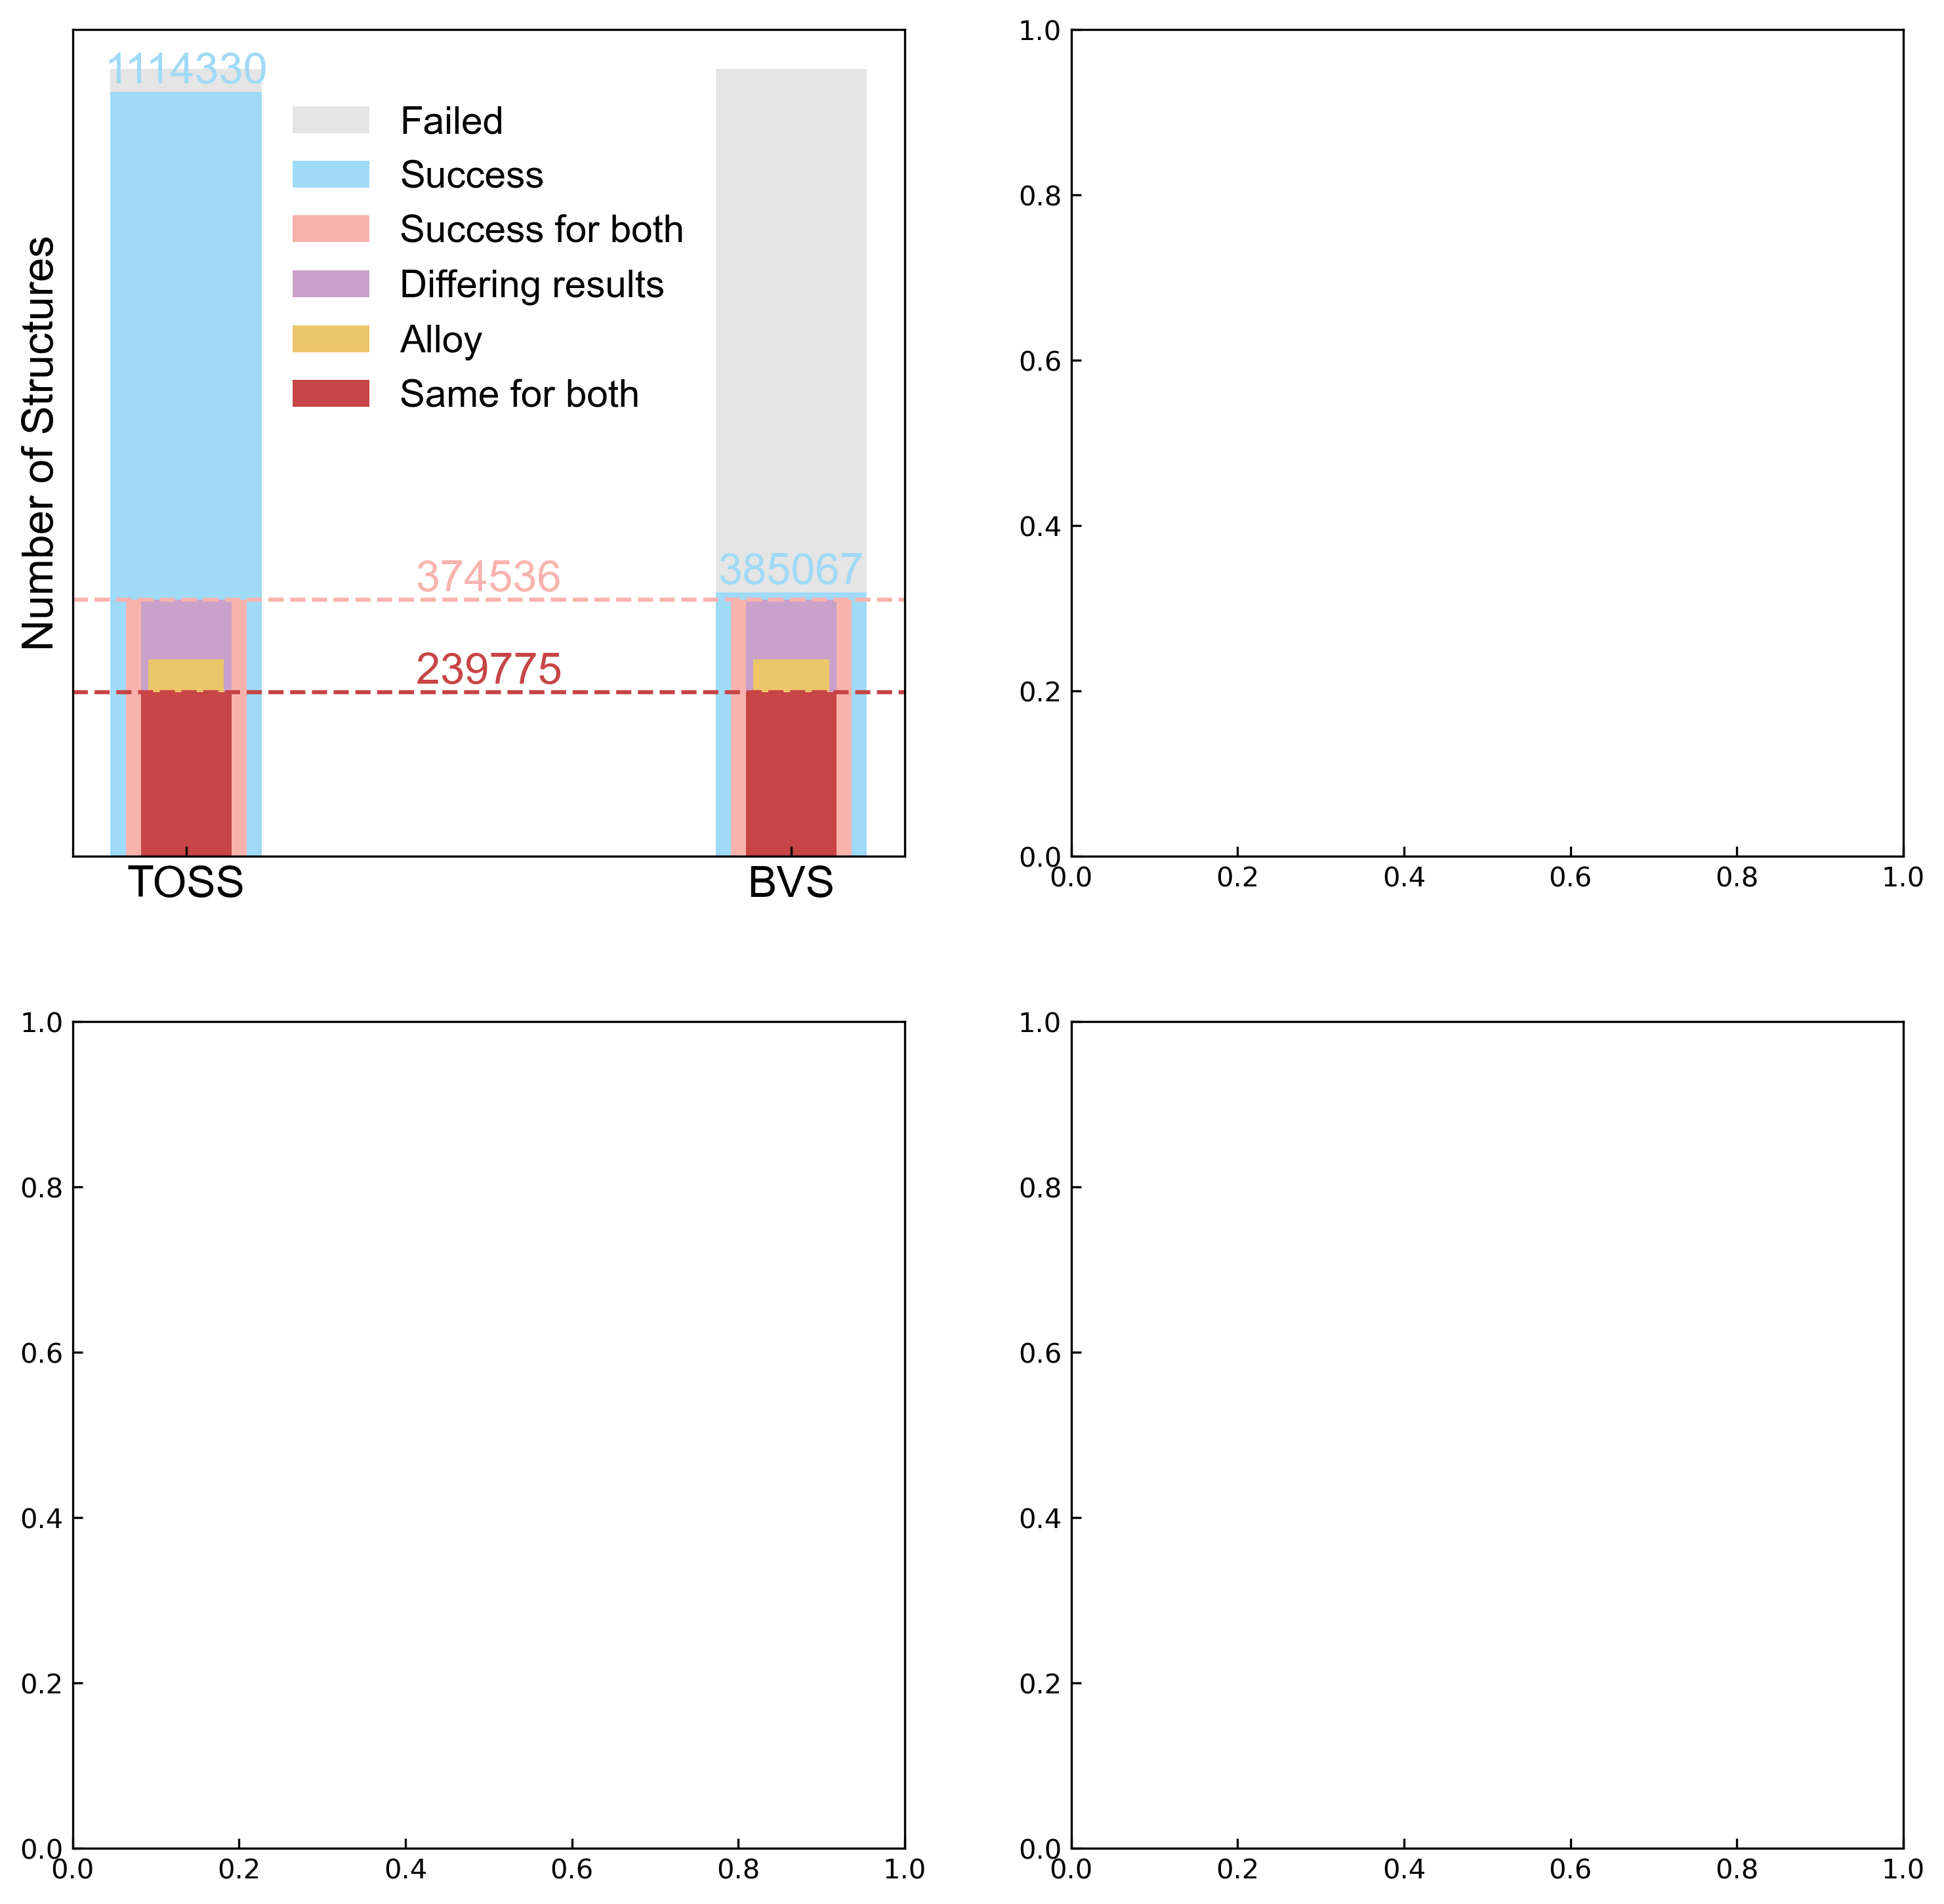

In [10]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colorbar import Colorbar
from matplotlib.cm import ScalarMappable

fig, gs = plt.figure(figsize=(12, 12), dpi=300), GridSpec(2, 2)
ax1, ax2, ax3, ax4 = plt.subplot(gs[0:1, 0:1]), plt.subplot(gs[0:1, 1:2]), plt.subplot(gs[1:2, 0:1]), plt.subplot(gs[1:2, 1:2])



################################################# Fig One! #################################################
stat = {"total":1147168,"toss":1114330,"BVS":385067,"both":373177,"same":250512,"right":8482+8381,"uncertain":12909+27391+31756,"alloy":33746}
assert stat["both"] == stat["uncertain"] + stat["same"] + stat["right"] + stat["alloy"]

bar_width = 0.25
text_size = 16
label_size = 16
legend_size = 14

###
index=0
ax1.bar(index, stat["total"], bar_width, label='Failed', color="darkgray", alpha=0.3)#"#D9DEE7"
ax1.bar(index, stat["toss"], bar_width, label='Success', color="#9FDAF7")
ax1.bar(index, stat["both"], bar_width*0.80, label='Success for both', color="#F9B3AD")
ax1.bar(index, stat["uncertain"]+stat["right"]+stat["alloy"], bar_width*0.60, bottom=stat["same"], label="Differing results", color="#C9A1CA")
ax1.bar(index, stat["alloy"], bar_width*0.50, bottom=stat["same"], label='Alloy', color="#EDC66A")
ax1.bar(index, stat["same"], bar_width*0.60, label='Same for both', color="#C74546")
ax1.text(x=index, y=stat["toss"], s=str(stat["toss"]), fontsize=text_size, ha='center', va='bottom', fontname='Arial', color="#9FDAF7")

index=1
ax1.bar(index, stat["total"], bar_width, color="darkgray", alpha=0.3)
ax1.bar(index, stat["BVS"], bar_width, color="#9FDAF7")
ax1.bar(index, stat["both"], bar_width*0.80, color="#F9B3AD")
ax1.bar(index, stat["uncertain"]+stat["right"]+stat["alloy"], bar_width*0.60, bottom=stat["same"], color="#C9A1CA")
ax1.bar(index, stat["alloy"], bar_width*0.50, bottom=stat["same"], color="#EDC66A")
ax1.bar(index, stat["same"], bar_width*0.60,  color="#C74546")
ax1.text(x=index, y=stat["BVS"], s=str(stat["BVS"]), fontsize=text_size, ha='center', va='bottom', fontname='Arial', color="#9FDAF7")

#ax1.axhline(y=stat["total"], color="#D9DEE7", linestyle='--')
ax1.axhline(y=stat["both"], color="#F9B3AD", linestyle='--')
ax1.text(x=0.5, y=stat["both"], s=str(stat["both"]), fontsize=text_size, ha='center', va='bottom', fontname='Arial', color="#F9B3AD")
ax1.axhline(y=stat["same"], color="#C74546", linestyle='--')
ax1.text(x=0.5, y=stat["same"], s=str(stat["same"]), fontsize=text_size, ha='center', va='bottom', fontname='Arial', color="#C74546")
##

ax1.set_ylim([0, stat["total"]*1.05])
ax1.set_yticks([], fontsize=label_size, fontname='Arial')
ax1.set_ylabel('Number of Structures', fontsize=label_size, fontname='Arial')
ax1.set_yticklabels(ax1.get_yticks(), fontdict={'family': 'Arial', 'size': label_size})

ax1.set_xticks([0,1])
ax1.set_xticklabels(["TOSS", "BVS"], fontsize=label_size, fontname='Arial')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), prop={'size': legend_size, 'family': 'Arial'},frameon=False)

ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))





################################################# Fig Two! #################################################
label_size = 16
tick_size = 10
string_size = 12

#acc = {"Simple-GCN":98.05, "GAT":97.95, "AttentiveFP":97.56, "MPNN":96.09, "XGBoost":96.00, "RF":95.89}
def extract_acc(model_name):
    name_dict = {"GCN":"Simple-GCN", "GAT":"GAT", "AFP":"AttentiveFP", "MPNN":"MPNN", "XGB":"XGBoost", "RF":"RF"}
    try:
        date = max(list(filter(None, list(map(lambda f:int(f.split("_")[-1].split(".")[0]) if model_name in f and "Hetero" not in f else None, os.listdir("../models/"))))))
        pd_res = pd.read_csv("../models/pyg_%s_s_0%s.txt"%(model_name,date), 
                         names=["epoch","time","tr_roc","tr_prc","tr_abs","vl_roc","vl_prc","vl_abs","te_roc","te_prc","te_abs"])
        return {name_dict[model_name]:max(pd_res["te_abs"].to_list())}
    except:
        res = pd.read_csv("../models/%s_2000.txt"%model_name, names=["ROC", "roc", "ABS", "abs"], sep="[:,]")
        return {name_dict[model_name]:round(float(res["abs"].to_list()[-1][0:6])*100,2)}

acc = {}
for mname in ["GCN", "GAT", "AFP", "MPNN","XGB","RF"]:
    acc.update(extract_acc(mname))
    

x = np.arange(len(acc))
y = np.array(list(acc.values()))
ax2.bar(x, y, color='#9FDAF7')

for xx,yy in zip(x,y):
    ax2.text(xx, yy, f"{yy:.2f}", ha='center', va='bottom', color='black', fontsize=string_size, fontname='Arial')


ax2.set_xlabel('Model Name', fontsize=label_size, fontname='Arial')
ax2.set_ylabel('Test Accuracy (%)', fontsize=label_size, fontname='Arial')

ax2.set_xticks(x)
ax2.set_xticklabels(acc.keys(), fontsize=tick_size, fontname='Arial')
ax2.set_ylim(90, 99.9)




################################################# Fig Three! #################################################
tick_labels = [f'+{i}' if i >= 0 else str(i) for i in range(-4, 8)]
cmap = colors.LinearSegmentedColormap.from_list("", [[0.0, '#9FDAF7'], [1.0, '#F9B3AD']])

string_size = 7
tick_size = 12
label_size = 16

cax = ax3.imshow(NC_CM, cmap=cmap, vmin=0, vmax=1)  # Adjust the colormap and vmin/vmax as needed

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax3.text(j, i, f"{NC_CM[i, j]*100:.1f}%", ha='center', va='center', color='black', fontsize=string_size, fontname='Arial')

ax3.set_xticks(np.arange(len(tick_labels)))
ax3.set_yticks(np.arange(len(tick_labels)))
ax3.set_xticklabels(tick_labels, fontsize=tick_size, fontname='Arial')
ax3.set_yticklabels(tick_labels, fontsize=tick_size, fontname='Arial')
ax3.set_xlabel('Predicted OS', fontsize=label_size, fontname='Arial')
ax3.set_ylabel('True OS', fontsize=label_size, fontname='Arial')

for i in range(len(tick_labels) + 1):
    ax3.axhline(i - 0.5, color='black', linewidth=1)
    ax3.axvline(i - 0.5, color='black', linewidth=1)

ax3.grid(False)
ax3.invert_yaxis() 
ax3.tick_params(axis='y', which='both', left=False)
ax3.tick_params(axis='x', which='both', bottom=False)



################################################# Fig Four! #################################################
data = [i[1] for i in True_length_Acc_dict]
radii = [i[0]/4 for i in True_length_Acc_dict]
w = [round(100/len(radii), 3)] * len(radii)

label_size = 16
text_size = 8

class LogNorm(Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        log_vmin = np.log(self.vmin)
        log_vmax = np.log(self.vmax)
        return (np.log(value) - log_vmin) / (log_vmax - log_vmin)

cmap_colors = [(0.0, '#9FDAF7'),(1.0, '#F9B3AD')]
cmap = mcolors.LinearSegmentedColormap.from_list("", cmap_colors)
#cmap_colors = [(0.0, cmap(0.1)), (0.95, cmap(0.3)), (0.96, cmap(0.4)), (0.97, cmap(0.5)), (0.98, cmap(0.6)), (0.99, cmap(0.8)), (1.0, cmap(1.0))]
#cmap = mcolors.LinearSegmentedColormap.from_list("", cmap_colors)

discrete_colors = [cmap(0.0),cmap(0.1),cmap(0.2),cmap(0.3),cmap(0.4),cmap(0.5),cmap(0.6),cmap(0.7),cmap(0.8),cmap(0.9),cmap(1.0)]
discrete_cmap = mcolors.ListedColormap(discrete_colors)


color_data = [discrete_cmap((x-0.955)*20) for x in data]
color_matrix = [[(0.0, 0.0, 0.0, 0.0)] * len(data) for _ in range(len(data))]

for i in range(len(data)):
    for j in range(i, len(data)):
        color_matrix[i][j] = color_data[j]
        

True_label=[str(round(x,1))+"Å" for x in [i[0] for i in True_length_Acc_dict]]


for i in range(len(data)):
    temp_label = [""]*len(data)
    if i%2==0:
        temp_label[i] = "  "+True_label[i] 
    ax4.pie(w, colors=color_matrix[i], startangle=90, counterclock=False, 
            textprops={'color': 'black', 'fontfamily':'Arial', 'fontsize': text_size, 'horizontalalignment':'center'}, labels=temp_label,
            radius=radii[i], wedgeprops={'width':radii[i], 'edgecolor': 'none', 'linewidth': 0})



ax4.set_ylim([-1.0,1.5])
ax4.set_xlim([-1.3,0.7])


sm = ScalarMappable(norm=mcolors.Normalize(vmin=min(data), vmax=max(data)), cmap=discrete_cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax4, orientation='horizontal', location='bottom', pad=0.06,)
cbar.set_ticks([0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0])
cbar.ax.set_xticklabels(['96%','96.5%', '97%', '97.5%','98%', '98.5%','99%', '99.5%','100%'])
cbar.set_label('Accuracy Colorscale', fontsize=label_size, fontname='Arial')


plt.subplots_adjust(wspace=0.3)
plt.show()
fig.savefig("Fig_4.svg")

# SI

# Fig.1

In [ ]:
file_get = open("../MOT.pkl", 'rb') 
MOT = pickle.load(file_get) 
file_get.close()


fig,gs = plt.figure(figsize=(54,16), dpi=300), GridSpec(1, 3)
ax1,ax2,ax3 = plt.subplot(gs[0:1,0:1]),plt.subplot(gs[0:1,1:2]),plt.subplot(gs[0:1,2:3])
axs = [ax1,ax2,ax3]


openexcel = pd.read_excel('../pre_set.xlsx', sheet_name = "Radii_X") 
dic_s = openexcel.set_index("symbol").to_dict()["single"]



epoch_threshold_list = []
for MT in MOT:
    threshold_list, pyykko_list = [], []
    for k,v in fitting_info.items():
        ele1, ele2 = k
        threshold_list.append(MT[element_list.index(ele1)][element_list.index(ele2)])
        pyykko_list.append(np.array(dic_s[k[0]]+dic_s[k[1]])*0.01)
    epoch_threshold_list.append((threshold_list, pyykko_list))

picked_epoch = [0, 5, 11]
picked_epoch_threshold_list = [epoch_threshold_list[p] for p in picked_epoch]
for ((threshold_list, pyykko_list), ax, epoch) in zip(picked_epoch_threshold_list, axs, picked_epoch):
    pyykko_list, threshold_list = np.array(pyykko_list), np.array(threshold_list)
    
    ax.scatter(pyykko_list, threshold_list, color='#0088FF', label='Thresholds', alpha=1)
    ax.fill([0, 7, 7/2], [0, 7*1.5, 7*1.5], color='#F9B3AD', alpha=0.3, label='Above 1.5*(Ra+Rb)', linewidth=0) 
    ax.fill([0, 7, 7], [0, 7, 7*1.5], color='#0088FF', alpha=0.3, label='Below 1.5*(Ra+Rb)', linewidth=0) 
    ax.plot([0, 7], [0, 10.5], linestyle='--', color='#D9DEE7', linewidth=line_size)

    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)
    ax.set_xlim([0,6.5])
    ax.set_ylim([0,6.5])
    ax.set_title("epoch=%s"%epoch, fontsize=label_size, fontname='Times New Roman')
    ax.set_xlabel("Sum of Pyykko Radii", fontsize=label_size, fontname='Times New Roman')
    ax.set_ylabel("Threshold", fontsize=label_size, fontname='Times New Roman')
    ax.legend(loc='lower right', prop={'size': legend_size, 'family': 'Times New Roman'}, frameon=False)
    
plt.subplots_adjust(left=0.05, right=0.98, bottom=0.08, top=0.95, wspace=0.25)
#fig.savefig("SI_Fig_1.svg")
plt.show()

# Fig.2

In [ ]:
import pandas as pd
import numpy as np
import pickle
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

OV = pd.read_csv("../redefined_length_csv/bond_of_O_V.csv", header=None)[0].tolist()
OAl = pd.read_csv("../redefined_length_csv/bond_of_O_Al.csv", header=None)[0].tolist()

with open("../fitting_info_dict.pkl", "rb") as f:
    fitting_info = pickle.load(f)


def refine_data(Min, Max, step, target_list):
    stations = np.arange(Min, Max + step, step)
    stations = np.round(stations, 3)
    def find_station(value):
        station_indices = np.searchsorted(stations, value, side='right') - 1
        return stations[max(station_indices, 0)]
    processed_list = [find_station(value) for value in target_list]
    return processed_list

def length_2_distribution(length, t):
    length = [l for l in length if t >= l > 0.1]
    Min, Max = min(length), max(length)
    Step = round(((Max-Min)/50),3)
    refined_distance = refine_data(Min, Max, Step, length)
    unique_values, counts = np.unique(refined_distance, return_counts=True)
    return unique_values, counts/sum(counts)


def gaussian(x, amplified1, mean1, stddev1, amplified2, mean2, stddev2):
    return amplified1 * np.exp((-(x-mean1)**2)/(2*(stddev1**2))) + amplified2 * np.exp((-(x-mean2)**2)/(2*(stddev2**2)))


def test_r2(x, y, mean1, mean2, step, MIN,MAX):
    bounds = ([0,mean1-0.1*step, 0, 0,mean2-0.1*step, 0], 
              [0.2,mean1+0.1*step,(MAX-MIN)/8,1 ,mean2+0.1*step,(MAX-MIN)/8])
    popt, _ = curve_fit(gaussian, x, y, bounds = bounds)
    y_pred = [gaussian(X,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]) for X in x]
    y_true = y
    R2 = r2_score(y_true,y_pred)
    RMSQ = mean_squared_error(y_true,y_pred, squared=False)
    return R2,popt,RMSQ,bounds    

In [ ]:
fig,gs = plt.figure(figsize=(54,16), dpi=300), GridSpec(1, 3)
ax1,ax2,ax3 = plt.subplot(gs[0:1,0:1]),plt.subplot(gs[0:1,1:2]),plt.subplot(gs[0:1,2:3])

label_size = 48
tick_size = 36
legend_size = 36


############# Fig One ################
_,__,___,____,_____,threshold = fitting_info[("O", "Al")].values()
x,y = length_2_distribution(OAl, threshold)


MIN = round(min(x),3)
MAX = round(max(x),3)
step = round(((MAX-MIN)/50),3)

np_mean1, np_mean2 = np.arange(MIN, MAX, step),np.arange(MIN, MAX, step)
dim = len(np_mean1)

np_R2, np_RMSQ = np.zeros([dim,dim]),np.zeros([dim,dim])
check_R2_list,check_mean_list = [],[]

for i, mean1 in enumerate(np_mean1):
    for j, mean2 in enumerate(np_mean2):
        try:
            R2, popt, RMSQ, bounds = test_r2(x, y, mean1, mean2, step, MIN, MAX)
            R2 = 0 if R2 < 0 else R2
            np_R2[i][j] = R2
            np_R2[j][i] = R2
            np_RMSQ[i][j] = RMSQ
            np_RMSQ[j][i] = RMSQ
            check_R2_list.append(R2)
            check_mean_list.append([mean1, mean2])
        except Exception as e:
            print(f"An error occurred: {e}")
            np_R2[i][j] = 0
            np_R2[j][i] = 0
            np_RMSQ[i][j] = max(np_RMSQ.flat)
            np_RMSQ[j][i] = max(np_RMSQ.flat)        
        if i == j:
            np_R2[i][j] = R2
            np_RMSQ[i][j] = RMSQ
            check_R2_list.append(R2)
            check_mean_list.append([mean1, mean2])


best_mean_combo = [j for i,j in zip(check_R2_list, check_mean_list) if i == max(check_R2_list)][0]
mean1, mean2 = best_mean_combo[0], best_mean_combo[1]
R2,popt,RMSQ,bounds = test_r2(x,y,mean1, mean2, step, MIN,MAX)
        

ax1.contourf(np_mean1, np_mean2, np_R2, 20, cmap="plasma")
ax1.set_xlabel("Mean_1 (Å)", fontsize=label_size, fontname='Times New Roman')
ax1.set_ylabel("Mean_2 (Å)", fontsize=label_size, fontname='Times New Roman')
ax1.tick_params(axis='x', labelsize=tick_size)
ax1.tick_params(axis='y', labelsize=tick_size)



############# Fig Two ################
_,__,___,____,_____,threshold = fitting_info[("O", "V")].values()
x,y = length_2_distribution(OV, threshold)


MIN = round(min(x),3)
MAX = round(max(x),3)
step = round(((MAX-MIN)/50),3)

np_mean1, np_mean2 = np.arange(MIN, MAX, step),np.arange(MIN, MAX, step)
dim = len(np_mean1)

np_R2, np_RMSQ = np.zeros([dim,dim]),np.zeros([dim,dim])
check_R2_list,check_mean_list = [],[]

for i, mean1 in enumerate(np_mean1):
    for j, mean2 in enumerate(np_mean2):
        try:
            R2, popt, RMSQ, bounds = test_r2(x, y, mean1, mean2, step, MIN, MAX)
            R2 = 0 if R2 < 0 else R2
            np_R2[i][j] = R2
            np_R2[j][i] = R2
            np_RMSQ[i][j] = RMSQ
            np_RMSQ[j][i] = RMSQ
            check_R2_list.append(R2)
            check_mean_list.append([mean1, mean2])
        except Exception as e:
            print(f"An error occurred: {e}")
            np_R2[i][j] = 0
            np_R2[j][i] = 0
            np_RMSQ[i][j] = max(np_RMSQ.flat)
            np_RMSQ[j][i] = max(np_RMSQ.flat)        
        if i == j:
            np_R2[i][j] = R2
            np_RMSQ[i][j] = RMSQ
            check_R2_list.append(R2)
            check_mean_list.append([mean1, mean2])


best_mean_combo = [j for i,j in zip(check_R2_list, check_mean_list) if i == max(check_R2_list)][0]
mean1, mean2 = best_mean_combo[0], best_mean_combo[1]
R2,popt,RMSQ,bounds = test_r2(x,y,mean1, mean2, step, MIN,MAX)
        

ax2.contourf(np_mean1, np_mean2, np_R2, 20, cmap="plasma")
ax2.set_xlabel("Mean_1 (Å)", fontsize=label_size, fontname='Times New Roman')
ax2.set_ylabel("Mean_2 (Å)", fontsize=label_size, fontname='Times New Roman')
ax2.tick_params(axis='x', labelsize=tick_size)
ax2.tick_params(axis='y', labelsize=tick_size)


############# Fig Three ################
plotting_R2_lists = sorted(list(map(lambda v:v["R2"], fitting_info_dict.values())))
x = [i for i in range(len(plotting_R2_lists))]
ax3.scatter(x, plotting_R2_lists, color='#0088FF', label='R2', alpha=1)

ax3.set_xlabel("Enumeration (#)", fontsize=label_size, fontname='Times New Roman')
ax3.set_ylabel("R2_score", fontsize=label_size, fontname='Times New Roman')
ax3.tick_params(axis='x', labelsize=tick_size)
ax3.tick_params(axis='y', labelsize=tick_size)
ax3.legend(loc='lower right', prop={'size': legend_size, 'family': 'Times New Roman'})


plt.subplots_adjust(left=0.05, right=0.98, bottom=0.08, top=0.95, wspace=0.25)
fig.savefig("SI_Fig_2.svg")
plt.show()

# Fig.3

In [ ]:
with open("../toss_page/bond_finder/without_Alloys_bond_parameters.json", 'r') as file:
    bp_dict = json.load(file)  
with open("../toss_page/specie_finder/specie_parameters.json", 'r') as file:
    sp_dict = json.load(file)

In [ ]:
import re

xmean, ymean = [], []
xsigma, ysigma = [], []

for bond_label, bond_info in bp_dict.items():
    parts = re.sub(r'^\(\(|\)\)$', '', bond_label).split('),(')
    ele1,ele2 = parts[0].split(',')
    [CN1,CN2] = list(map(lambda x:int(x), parts[1].split(',')))
    [OS1,OS2] = list(map(lambda x:int(x), parts[2].split(',')))
    mean, sigma, number = float(bond_info["M"]), float(bond_info["S"]), bond_info["N"]
    
    specie1_infos = sp_dict[ele1]
    specie2_infos = sp_dict[ele2]
    
    smean1, ssigma1 = None, None
    for info1 in specie1_infos:
        if int(info1["CN"]) == CN1 and int(info1["OS"]) == OS1:
            smean1 = float(info1["R"])
            ssigma1 = float(info1["S"])
            
    smean2, ssigma2 = None, None
    for info2 in specie2_infos:
        if int(info2["CN"]) == CN2 and int(info2["OS"]) == OS2:
            smean2 = float(info2["R"])
            ssigma2 = float(info2["S"])
    
    if smean1 != None and smean2 != None:
        xmean.append(smean1 + smean2)
        ymean.append(mean)
        xsigma.append(ssigma1 + ssigma2)
        ysigma.append(sigma**2)

In [ ]:
import random

fig,gs = plt.figure(figsize=(36,16), dpi=100), GridSpec(1, 2)
ax1,ax2 = plt.subplot(gs[0:1,0:1]),plt.subplot(gs[0:1,1:2])

label_size = 48
tick_size = 36
legend_size = 36

ratio = 0.1
num = len(xmean)
random_index = random.sample([i for i in range(num)], round(num*ratio))

xmean, ymean = [xmean[i] for i in random_index], [ymean[i] for i in random_index]
xsigma, ysigma = [xsigma[i] for i in random_index], [ysigma[i] for i in random_index]

ax1.scatter(xmean, ymean, color='#9FDAF7', label='Mean', alpha=1)
ax1.set_xlim([0,7])
ax1.set_ylim([0,7])
ax1.set_xlabel("Sum of Radii", fontsize=label_size, fontname='Times New Roman')
ax1.set_ylabel("Mean Bond Length", fontsize=label_size, fontname='Times New Roman')
ax1.tick_params(axis='x', labelsize=tick_size)
ax1.tick_params(axis='y', labelsize=tick_size)
ax1.legend(loc='lower right', prop={'size': legend_size, 'family': 'Times New Roman'})


ax2.scatter(xsigma, ysigma, color='#F9B3AD', label='Variance', alpha=1)
ax2.set_xlim([-0.05, 1])
ax2.set_ylim([-0.05, 1])
ax2.set_xlabel("Sum of Variances", fontsize=label_size, fontname='Times New Roman')
ax2.set_ylabel("Variance of Bond Length", fontsize=label_size, fontname='Times New Roman')
ax2.tick_params(axis='x', labelsize=tick_size)
ax2.tick_params(axis='y', labelsize=tick_size)
ax2.legend(loc='lower right', prop={'size': legend_size, 'family': 'Times New Roman'})


plt.subplots_adjust(left=0.05, right=0.98, bottom=0.08, top=0.95, wspace=0.25)
plt.show()
fig.savefig("SI_Fig_3.svg")

# Fig.S4

In [ ]:
if not os.path.exists("models_result.pkl"):
    
    result_dict = {"GCN":{"training":None, "result":None}, 
                   "GAT":{"training":None, "result":None}, 
                   "AFP":{"training":None, "result":None}, 
                   "MPNN":{"training":None, "result":None}}
    
    names = ["epoch","cost","tr_roc","tr_prc","tr_abs","vl_roc","vl_prc","vl_abs","te_roc","te_prc","te_abs"]

    GCN = pyg_GCNPredictor(in_feats=15, hidden_feats=[256, 256, 256, 256], 
                                         activation=None, residual=None, batchnorm=None, dropout=None, 
                                         predictor_hidden_feats=64, n_tasks=12, predictor_dropout=0.3) 
    GCN.load_state_dict(torch.load("../models/pyg_GCN_s_0512.pth"))
    result_dict["GCN"]["training"] = pd.read_csv("../models/pyg_GCN_s_0512.txt",names=names)

    GAT = pyg_GATPredictor(in_feats=15, hidden_feats=[64, 64, 64, 64], num_heads=[4, 4, 4, 4], 
                                         dropouts=None, biases=None, alphas=None, activations=None, agg_modes=None, 
                                         predictor_hidden_feats=64, n_tasks=12, predictor_dropout=0.3)
    GAT.load_state_dict(torch.load("../models/pyg_GAT_s_0524.pth"))
    result_dict["GAT"]["training"] = pd.read_csv("../models/pyg_GAT_s_0524.txt",names=names)

    AFP = pyg_AFPPredictor(node_feat_size=15, edge_feat_size=13, dropout=0.,
                                         num_layers=4, graph_feat_size=256, 
                                         predictor_hidden_feats=64, n_tasks=12, predictor_dropout=0.3)
    AFP.load_state_dict(torch.load("../models/pyg_AFP_s_0525.pth"))
    result_dict["AFP"]["training"] = pd.read_csv("../models/pyg_AFP_s_0525.txt",names=names)

    MPNN = PyG_MPNNPredictor(node_in_feats=15, edge_in_feats=13, node_out_feats=16, edge_hidden_feats=256, 
                                         num_step_message_passing=4,
                                         n_tasks=12, predictor_hidden_feats=64, predictor_dropout=0.3)
    MPNN.load_state_dict(torch.load("../models/pyg_MPNN_s_0525.pth"))
    result_dict["MPNN"]["training"] = pd.read_csv("../models/pyg_MPNN_s_0525.txt",names=names)

    dataset = TOSS_PYG_NC_MEF_DataSet(root="../").shuffle() 
    data_loader = PYG_DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=PYG_NC_collate, drop_last = False)

    def unencode(l):
        l = list(l)
        classes=["-4","-3","-2","-1","0","1","2","3","4","5","6","7"]
        return classes[l.index(max(l))]


    for model_name in result_dict.keys():
        exec("model = %s"%model_name)
        model.eval()
        eval_matrix = measure_matrix()

        with torch.no_grad():
            for batch_id, batch_data in enumerate(data_loader):
                batch_data = batch_data.to('cuda:0')
                labels = batch_data.y.to('cuda:0')

                model = model.to("cuda:0")

                outputs = model(batch_data)

                torch.cuda.empty_cache()
                masks = torch.ones(labels.shape)
                eval_matrix.update(outputs, labels, masks)
            abs_score = eval_matrix.absolute_correct_rate() *  100

        all_true = np.vstack((eval_matrix.y_true))
        all_pred = np.vstack((eval_matrix.y_pred))

        ALL_PRED = list(map(unencode, all_pred))
        ALL_TRUE = list(map(unencode, all_true))

        result_dict[model_name]["result"] = metrics.confusion_matrix(ALL_PRED, ALL_TRUE, normalize="true")

    file_save = open("models_result.pkl",'wb') 
    pickle.dump(result_dict, file_save) 
    file_save.close()
else:
    file_get = open("models_result.pkl", 'rb') 
    result_dict = pickle.load(file_get) 
    file_get.close()

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import matplotlib.colors as mcolors

#fig,gs = plt.figure(figsize=(36,16), dpi=100), GridSpec(1, 2)
#ax1,ax2 = plt.subplot(gs[0:1,0:1]),plt.subplot(gs[0:1,1:2])

line_size = 3
tick_size = 36
label_size = 48
text_size = 36
legend_size = 48

for model_name, model_info in result_dict.items():
    fig,gs = plt.figure(figsize=(36,16), dpi=100), GridSpec(1, 2)
    ax1,ax2 = plt.subplot(gs[0:1,0:1]),plt.subplot(gs[0:1,1:2])
    
    model_training = model_info["training"]
    model_result = model_info["result"]
     
    train_abs = model_training["tr_abs"]
    #validation_abs = model_training["vl_abs"]
    test_abs = model_training["te_abs"]
    x = np.arange(len(train_abs))
    
    max_rate = max(list(test_abs))
    max_index = list(test_abs).index(max_rate)
    
    ax1.plot(x, train_abs, color="#F9B3AD", linewidth=line_size, label="Training Accuracy")
    #ax1.plot(x, validation_abs, color="#F9B3AD", linewidth=line_size, label="Validation Accuracy")
    ax1.plot(x, test_abs, color="#9FDAF7", linewidth=line_size, label="Test Accuracy")
    ax1.annotate("%s"%max_rate, xy=[max_index,max_rate], xytext=[max_index-10, max_rate+0.3], 
                 fontsize=text_size, ha='right', va="bottom", arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
    ax1.set_ylim([94, 99])
    
    ax1.set_xlabel('Epoch', fontsize=label_size, fontname='Arial')
    ax1.set_ylabel('Node Accuracy (%)', fontsize=label_size, fontname='Arial')
    ax1.tick_params(axis='x', labelsize=tick_size)
    ax1.tick_params(axis='y', labelsize=tick_size)
    ax1.legend(loc='upper left', prop={'size': legend_size, 'family': 'Arial'},frameon=False)
    
    tick_labels = [f'+{i}' if i >= 0 else str(i) for i in range(-4, 8)]
    cmap = colors.LinearSegmentedColormap.from_list("", [[0.0, '#9FDAF7'], [1.0, '#F9B3AD']])

    string_size = 24
    tick_size = 36
    label_size = 48

    cax = ax2.imshow(model_result, cmap=cmap, vmin=0, vmax=1)  # Adjust the colormap and vmin/vmax as needed

    for i in range(len(tick_labels)):
        for j in range(len(tick_labels)):
            ax2.text(j, i, f"{model_result[i, j]*100:.1f}%", ha='center', va='center', color='black', fontsize=string_size, fontname='Arial')

    ax2.set_xticks(np.arange(len(tick_labels)))
    ax2.set_yticks(np.arange(len(tick_labels)))
    ax2.set_xticklabels(tick_labels, fontsize=tick_size, fontname='Arial')
    ax2.set_yticklabels(tick_labels, fontsize=tick_size, fontname='Arial')
    ax2.set_xlabel('Predicted OS', fontsize=label_size, fontname='Arial')
    ax2.set_ylabel('True OS', fontsize=label_size, fontname='Arial')

    for i in range(len(tick_labels) + 1):
        ax2.axhline(i - 0.5, color='black', linewidth=1)
        ax2.axvline(i - 0.5, color='black', linewidth=1)

    ax2.grid(False)
    ax2.invert_yaxis() 
    ax2.tick_params(axis='y', which='both', left=False)
    ax2.tick_params(axis='x', which='both', bottom=False)
    
    plt.subplots_adjust(left=0.05, right=0.98, bottom=0.08, top=0.95, wspace=0.25)
    plt.show()

#fig.savefig("SI_Fig_3.svg")

# Fig.S5

In [ ]:
pinfo = []
for e in element_list:
    try:
        pinfo.append((e, int(elements_const[e]["N"])))
    except:
        pinfo.append((e,0))
        
pinfo = sorted(pinfo, key=lambda x:x[1])
pe, pn = zip(*pinfo)

fig = plt.figure(figsize=(20, 10))
bars = plt.bar(pe, pn, color='skyblue')

plt.ylabel('Elements')
plt.xlabel('Values')
plt.ylim([0,1e6])
#plt.xlim([28,50])
plt.show()